# Predictions

In this notebook you will learn how to build a link prediction classifier using Neo4j and scikit-learn. 

Import the libraries that you will need (remember to unset Reset all runtimes before running):

In [3]:
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

Next, create a connection to your Neo4j Sandbox, just as you did previously when you set up your environment. 

<div align="left">
    <img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/sandbox-citations.png?raw=1" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.

In [4]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
#graph = Graph("bolt://52.3.242.176:33698", auth=("neo4j", "equivalent-listing-parts"))
graph = Graph("bolt://localhost:7687", auth=("neo4j", "graphdb"))

# Building a co-author graph

You will build an inferred graph of co-authors based on people collaborating on the same papers. You will store a property on the relationship indicating the year of their first collaboration.

Run this code to do this:

In [5]:
query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, paper
   ORDER BY a1, paper.year
   RETURN a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: False
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0

Now that you have created a co-author graph, you need an approach that will allow you to predict future links (relationships) that will be created between people. 

You will use the [link prediction algorithms](https://neo4j.com/docs/graph-algorithms/current/algorithms/linkprediction/) that you learned about in the previous section. Once you have computed scores with this algorithms what should you do?

There are two main approaches that one can take:

## Using the measures directly

You can use the scores from the link predictions directly, specifying a __threshold value__ above which we predict that a link will be created between two nodes.

## Supervised learning

You can take a supervised learning approach where you use the scores as features to train a binary classifier. The binary classifier then predicts whether a pair of nodes will have a link.

In this notebook you will apply the supervised learning approach.

## Train and test datasets 

Next, you must create the train and test datasets on which you can build, and then evaluate a model.

## Positive examples

The tricky thing when working with graph data is that you cannot just randomly split the data, as this could lead to data leakage.

Data leakage can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in the training set may be connected to those in the test set.

When you compute link prediction measures over that training set the __measures computed contain information from the test set__ that you will later evaluate the model against.

Instead, you need to split the graph into training and test sub graphs. If the graph has a concept of time, things are easier as you can split the graph at a point in time. The training set will be from before the time, the test set after.

This is still not a perfect solution and you must ensure that the general network structure in the training and test sub graphs is similar.

Subsequently, pairs of nodes in our train and test datasets will have relationships between them. They will be the __positive examples__ in your machine learning model.

Because the citation graph contains times, you can create train and test graphs by splitting the data on a particular year. Next, you must determine what year that should be. Determine the distribution of the first year that co-authors collaborated:

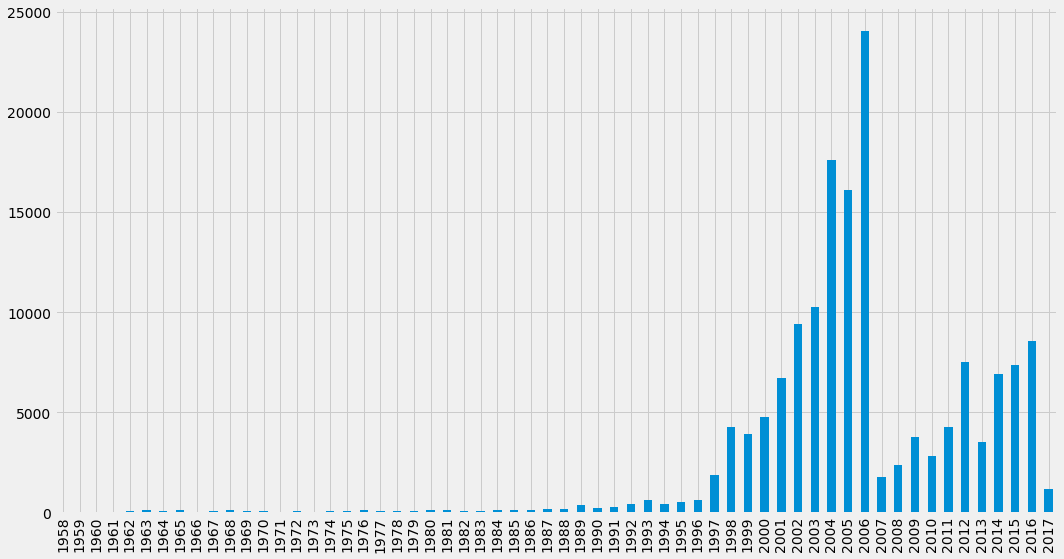

In [6]:
query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

It looks like 2006 would act as a good year for splitting the data. All co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

Create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in the graph based on that year. The following code will create these relationships:

In [7]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [8]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

Determine how many co-author relationship you have in each of these sub graphs:

In [9]:
query = """
MATCH ()-[:CO_AUTHOR_EARLY]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,81096


In [10]:
query = """
MATCH ()-[:CO_AUTHOR_LATE]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,74128


This graph has a split of 52-48, which is a bit on the high side, but should be ok. Next, we create our __negative examples__.


## Negative examples

The simplest approach is to use all pair of nodes that don’t have a relationship. __The problem with this approach is that there are significantly more examples of pairs of nodes that don’t have a relationship than there are pairs of nodes that do__.

The maximum number of negative examples is equal to:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```

i.e. the number of nodes squared, minus the relationships that the graph has, minus self relationships.

If you were to use all of these negative examples in your training set, you would have a massive class imbalance — there are many negative examples and relatively few positive ones.

A model trained using data that is this imbalanced will achieve very high accuracy by __predicting that any pair of nodes don’t have a relationship__ between them, which is not quite what we want!

You need to reduce the number of negative examples. An approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__.

This will significantly reduce the number of negative examples, although there will still be a lot more negative examples than positive.

To solve this problem, you either need to down sample the negative examples or up sample the positive examples.

You will take the down sampling approach. The following function will do this:

In [11]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

Now you are ready to build the train and test datasets based on the train and test sub graphs that you created. 

* The positive examples will be taken directly from the graph. 
* The negative examples will be found by looking for people who are 2 or 3 hops away from each other, excluding those that have already collaborated. You will then down sample those examples to equal the size of the positive examples. 

In [12]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [13]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

Now let's have a look what our train DataFrame contains:

In [14]:
training_df.head()

,node1,node2,label
737418,170025,161464,0
995019,52255,65799,1
914904,242817,18501,0
988693,50767,50768,1
981002,27840,27843,1


Let's repeat the process for the test set:

In [15]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [16]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

And it's time to sample our test DataFrame:

In [17]:
test_df.head()

,node1,node2,label
205175,51560,20580,0
332615,90548,78841,0
123820,27768,246291,0
1281052,106954,106955,1
280445,71528,205820,0


# Choosing a machine learning algorithm

Next, you will create a machine learning pipeline based on a random forest classifier. This method is well suited as this data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure that you don’t create a model that only fits the training data.

In [18]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

# Generating graphy features

Start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.

The following function computes each of these measures for pairs of nodes:

In [19]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

Now apply the function to the training DataFrame:

In [20]:
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

This is what the DataFrame looks like now:

In [21]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,170025,161464,0,0.000,28.000,11.000
1,52255,65799,1,1.000,16.000,9.000
2,242817,18501,0,0.000,39.000,16.000
3,50767,50768,1,5.000,48.000,9.000
4,27840,27843,1,2.000,18.000,7.000


Do the same to the test DataFrame:

In [22]:
test_df = apply_graphy_features(test_df, "CO_AUTHOR")

In [23]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,51560,20580,0,2.000,210.000,45.000
1,90548,78841,0,0.000,100.000,20.000
2,27768,246291,0,1.000,130.000,22.000
3,106954,106955,1,0.000,10.000,11.000
4,71528,205820,0,1.000,144.000,29.000


Next, you will build a model based on these graphy features. You will start by just using one of the features - common neighbors. 

The following code builds a random forest model, evaluates it against the test dataset, and then indicates which of the features had the most importance in the model.

In [24]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Next, you need to evaluate the model. You will compute its accuracy, precision, and recall. Then, you will return the importance of each feature used in the model. The following functions will help with this:

In [25]:
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

,Measure,Score
0,Accuracy,0.854
1,Precision,0.943
2,Recall,0.753


'Feature Importance'

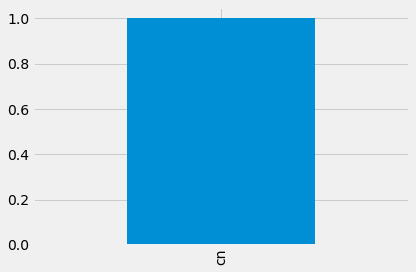

In [26]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The scores for accuracy and precision are adequate, but the recall is not very good. What happens if you include preferential attachment and total neighbors as well?

,Measure,Score
0,Accuracy,0.917
1,Precision,0.920
2,Recall,0.913


'Feature Importance'

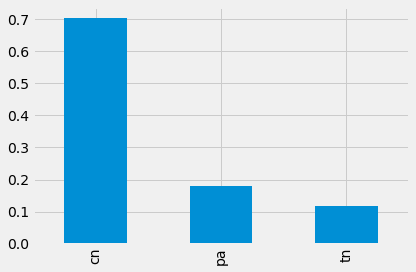

In [27]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Common Neighbors is the dominant feature, but including the two other features has improved the accuracy and recall of the model.

Next, you will add some new features that are generated from graph algorithms.

# Triangles and The Clustering Coefficient

Start by running the [triangle count](https://neo4j.com/docs/graph-algorithms/current/algorithms/triangle-counting-clustering-coefficient/) algorithm over the test and train sub-graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. The clustering coefficient of a node indicates the likelihood that its neighbors are also connected.

In [28]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,138,112,10,770,80299,91698,0.357,0,0,0,0,0,3,6,14,40,757,True,trianglesTrain,coefficientTrain


In [29]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,56,104,3,678,80299,184846,0.627,0,0,0,1,2,6,14,23,78,777,True,trianglesTest,coefficientTest


The following function will add these features to the train and test DataFrames:

In [30]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

Add the new features:

In [31]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [32]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,170025,161464,0,0.000,28.000,11.000,3,20,0.500,0.952
1,52255,65799,1,1.000,16.000,9.000,1,5,0.179,1.000
2,242817,18501,0,0.000,39.000,16.000,3,13,0.167,1.000
3,50767,50768,1,5.000,48.000,9.000,15,17,0.607,1.000
4,27840,27843,1,2.000,18.000,7.000,3,6,0.400,1.000


In [33]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,51560,20580,0,2.000,210.000,45.000,1,38,0.044,0.100
1,90548,78841,0,0.000,100.000,20.000,6,16,0.133,0.356
2,27768,246291,0,1.000,130.000,22.000,13,25,0.289,0.321
3,106954,106955,1,0.000,10.000,11.000,0,12,0.000,0.267
4,71528,205820,0,1.000,144.000,29.000,5,32,0.116,0.333


And now let's train and evaluate a model with these features:

,Measure,Score
0,Accuracy,0.947
1,Precision,0.945
2,Recall,0.949


'Feature Importance'

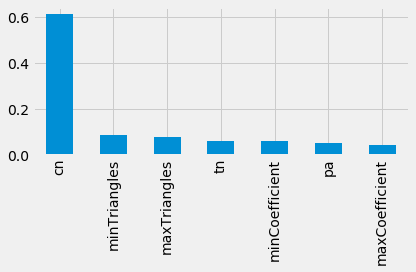

In [34]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The coefficient features have not added much to our model, but the triangles are useful. Next you will see if Community Detection algorithms can help improve the model.

# Community Detection

Community Detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities.

You will run two Community Detection algorithms over the train and test sub-graphs - Label Propagation and Louvain. First, Label Propagation: 

In [37]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

ClientError: ProcedureCallFailed: Failed to invoke procedure `algo.labelPropagation`: Caused by: java.lang.IllegalArgumentException: Node properties not found: 'partitionTrain'

In [36]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

ClientError: ProcedureCallFailed: Failed to invoke procedure `algo.labelPropagation`: Caused by: java.lang.IllegalArgumentException: Node properties not found: 'partitionTest'

And now Louvain. The Louvain algorithm returns intermediate communities, which are useful for finding fine grained communities that exist in a graph. You will add a property to each node containing the community revealed on the first iteration of the algorithm:

In [38]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [39]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

The following function will add these features to the train and test DataFrames:

In [40]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [41]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [42]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,170025,161464,0,0.000,28.000,11.000,3,20,0.500,0.952,0.000,0.000
1,52255,65799,1,1.000,16.000,9.000,1,5,0.179,1.000,0.000,0.000
2,242817,18501,0,0.000,39.000,16.000,3,13,0.167,1.000,0.000,0.000
3,50767,50768,1,5.000,48.000,9.000,15,17,0.607,1.000,0.000,1.000
4,27840,27843,1,2.000,18.000,7.000,3,6,0.400,1.000,0.000,1.000


In [43]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,51560,20580,0,2.000,210.000,45.000,1,38,0.044,0.100,0.000,0.000
1,90548,78841,0,0.000,100.000,20.000,6,16,0.133,0.356,0.000,0.000
2,27768,246291,0,1.000,130.000,22.000,13,25,0.289,0.321,0.000,0.000
3,106954,106955,1,0.000,10.000,11.000,0,12,0.000,0.267,0.000,1.000
4,71528,205820,0,1.000,144.000,29.000,5,32,0.116,0.333,0.000,0.000


,Measure,Score
0,Accuracy,0.961
1,Precision,0.958
2,Recall,0.964


'Feature Importance'

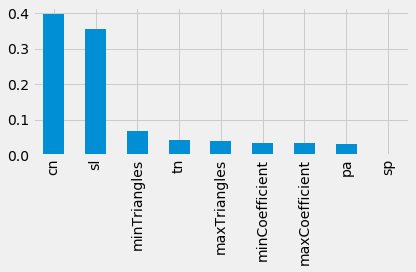

In [44]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)